In [287]:
import numpy as np
import pandas as pd
import networkx as nx
import math as math

import pandas as pd
import numpy as np
from PIL import Image
from scipy.integrate import odeint
from numpy import linalg as LA
from numpy.linalg import inv
from math import exp
from math import expm1
from scipy import linalg
from scipy.optimize import minimize

from yeastnet import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [111]:
# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, k_tf, kf, k_prot, Aa, Ai):
    '''
    u: N-vector of initial activation strength.
    k_tf: N-vector of TF strengths.
    kf: N-vector of feedbacks for each gene.
    k_prot: Protein constant.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = Aa - Ai
    #print(A.shape)
    A = (k_tf * A.transpose()).transpose()
    
    dm = A @ p - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

def error_prot_model(params, y_data, N, hss_indices, Aa, Ai, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    k_prot = params[-1]
    
    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, k_tf, kf, k_prot, Aa, Ai))
    m = y[:,:N]
    
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def get_predictions_f3(params, hss_indices, Aa, Ai, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=5,prot=False):
    N = Aa.shape[0]
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    #print('u0', len(u0))
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    #print('kf', len(kf), kf)
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    #print('k_tf', len(k_tf))
    k_prot = params[-1]
    #print(k_prot)

    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, k_tf, kf, k_prot, Aa, Ai),)
    if not prot:
        return y[:,:N]
    else:
        return y[:,N:2*N]

In [3]:
def combine_networks(act, inh):
    Aa = nx.adjacency_matrix(act).toarray()
    Ai = nx.adjacency_matrix(inh).toarray()
    W = Aa - Ai
    
    mixed_network = nx.DiGraph(data=np.array(W))
    names = act.nodes()
    mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})
    return mixed_network

def shortest_path_length(network, s, node):
    try:
        return nx.shortest_path_length(network, s, node)
    except:
        return np.inf

def shortest_path_to_hss(network, node, starters):
    #print(node)
    path_lengths = [shortest_path_length(network, s, node) for s in starters]
    return min(path_lengths)

In [4]:
# Read full network data.
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)

names = list(Aa)

Aa, Ai = np.array(Aa), np.array(Ai)

# Remove diagonal elements.
np.fill_diagonal(Aa, 0) 
np.fill_diagonal(Ai, 0)

# Turn into networkx objects.
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))


network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

W = Aa - Ai
mixed_network = nx.DiGraph(data=np.array(W))
mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})

In [5]:
def hss_successors(mixed_network, starters, only_tf=True):
    nodelist = []
    for node in mixed_network.nodes():
        # Check if there exists a path from any of the HSS to current node.
        if np.any([nx.has_path(mixed_network, st, node) for st in starters]):
            if not only_tf:
                nodelist.append(node)
            elif mixed_network.out_degree(node) != 0:
                nodelist.append(node)
    return nodelist

heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]

# Get TF successor subnetwork.
subnet_nodelist = hss_successors(mixed_network, heat_shock_starters, only_tf=True)
sn_act, sn_inh = network_act.subgraph(subnet_nodelist), network_inh.subgraph(subnet_nodelist)
sn = combine_networks(sn_act, sn_inh)
nodes = np.array(sn.nodes())

In [6]:
# Create first neighbor subnetworks.
path_lengths = np.array([shortest_path_to_hss(sn, node, heat_shock_starters) for node in sn.nodes()])

nodes1 = list(nodes[path_lengths <= 1])
sn1_act, sn1_inh = sn_act.subgraph(nodes1), sn_inh.subgraph(nodes1)

A1a, A1i = nx.adjacency_matrix(sn1_act), nx.adjacency_matrix(sn1_inh)
A1a, A1i = A1a.toarray().transpose(), A1i.toarray().transpose()

N = len(nodes1)
hss_indices = [nodes1.index(tf) for tf in heat_shock_starters]

I stored the model parameters from our fit with a library called pickle, that lets you save arbitrary Python objects.
I now load them and plot the results.

In [197]:
import pickle
fit_params = pickle.load(open('fit_params_subnetwork.p', 'rb'))

times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

# You can change this if you want higher resolution for the model timepoints. 
# I kind of find it better to just look at the same timepoints to more easily
# compare with data in this plot.
ts = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)

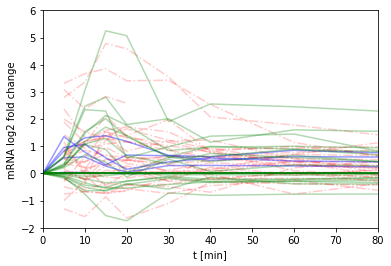

In [8]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-.', color="red", alpha=0.2)
plt.plot(ts, y_pred[:, hss_indices], '-', color="blue", alpha=0.4)
plt.plot(ts, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '-', color='green', alpha=0.3)
plt.xlabel('t [min]')
plt.ylabel('mRNA log2 fold change')
plt.xlim(0, 80)
plt.ylim(-2, 6)
plt.show()

In [9]:
?plt.legend

In [263]:
ts = np.arange(0, 90000, 0.1)
p_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5,prot=True)
def simulated_data(tf_index,t):
    if t>8000:
        return 0
    else:
        tceil=math.ceil(t/0.1)
        tfloor=tceil-1
        u1=p_pred[tfloor,tf_index]
        u2=p_pred[tceil,tf_index]
        yval = ((1-((t/0.1)-tfloor))*u1)+(((t/0.1)-tfloor)*u2)
        return yval

In [331]:
def fsingle(y, t0, k_tfs,kprot,parental_indices, kf):
    m=y[0]
    p=y[1]
    ypars = []
    for i in range(len(parental_indices)):
        ypars.append(k_tfs[i]*simulated_data(parental_indices[i],t0))
    yinfl=sum(ypars)
    dm = yinfl-kf*p
    dp = kprot*(m-p)
    return [dm,dp]

def error_single(kf,y_data, act_parents,inh_parents,params,nodes,s=36,e=67):
    k_tfs_tot=params[s:e]
    kprot=params[-1]
    k_tfs=[]
    tot_parents=list(set(act_parents) | set(inh_parents))
    parental_indices = []
    for parent in tot_parents:
        parental_indices.append(nodes.index(parent))
        if parent in set(act_parents):
            if parent not in set(inh_parents):
                k_tfs.append(k_tfs_tot[parental_indices[-1]])
            else:
                k_tfs.append(0)
        elif parent in set(inh_parents):
            if parent not in set(act_parents):
                k_tfs.append(-k_tfs_tot[parental_indices[-1]])
            else:
                k_tfs.append(0)    
    
    y = odeint(fsingle, y0=[0,0], t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(k_tfs, kprot,parental_indices,kf))
    m = y[:,0]
    
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def get_predicts_single(kf_fits,genes, network_act,network_inh,params,nodes,s=36,e=67):
    k_tfs_tot=params[s:e]
    kprot=params[-1]
    predict_data=np.array([])
    for i, gene in enumerate(genes):
        k_tfs=[]
        act_parents=list(network_act.predecessors(gene))
        inh_parents=list(network_inh.predecessors(gene))
        tot_parents=list(set(act_parents) | set(inh_parents))
        parental_indices = []
        for parent in tot_parents:
            parental_indices.append(nodes.index(parent))
            if parent in set(act_parents):
                if parent not in set(inh_parents):
                    k_tfs.append(k_tfs_tot[parental_indices[-1]])
                else:
                    k_tfs.append(0)
            elif parent in set(inh_parents):
                if parent not in set(act_parents):
                    k_tfs.append(-k_tfs_tot[parental_indices[-1]])
                else:
                    k_tfs.append(0)    
        y = odeint(fsingle, y0=[0,0], t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
                   args=(k_tfs, kprot,parental_indices,kf_fits[i]))
        m = y[:,0]
        if gene =='SCC2':
            predict_data=m
        else:
            predict_data=np.vstack((predict_data,m))
    return predict_data

In [459]:
def num_to_rgb(num,maxi):
    if num > 0:
        return [int(255*num/maxi), 0, 0]
    elif num < 0:
        return [0,int(-255*num/maxi),0]
    elif num ==0:
        return [0,0,0]
    else:
        return [0,0,255]
def make_plot(rawdata,filename,maxi=8,pixperpoint=10,linesperpoint=1):
    numrows=len(rawdata)
    numcols=len(rawdata[0])
    raw_pixel_data = np.zeros([numrows*linesperpoint,pixperpoint*numcols,3],dtype=np.uint8)
    for i in range(numrows):
        for j in range(numcols):
            for k in range(pixperpoint):
                for l in range(linesperpoint):
                    raw_pixel_data[linesperpoint*i+l,pixperpoint*j+k] = num_to_rgb(rawdata[i,j], maxi)
    img = Image.fromarray(raw_pixel_data, 'RGB')
    img.save(filename)

In [283]:
successors_no_other_preds=[]
for gene in tf_and_successors:
    if (set(network_act.predecessors(gene)) | set(network_inh.predecessors(gene))) <= set(nodes1):
        if gene in set(list(gasch_data.index)):
            successors_no_other_preds.append(gene)
successors_no_other_preds=list(set(successors_no_other_preds)-set(nodes1))
len(successors_no_other_preds)

236

In [284]:
kf_fitted=np.array([])
for gene in successors_no_other_preds:
    fit_output = minimize(error_single, x0=np.array([0.5]),
                  args=(np.array(gasch_data.iloc[:, 2:10].loc[gene]),list(network_act.predecessors(gene)),
                        list(network_inh.predecessors(gene)), fit_params.x, nodes1),bounds=[(0.01,1)])
    kf_fitted=np.concatenate([kf_fitted,fit_output.x])
    if successors_no_other_preds.index(gene) % 10 ==0:
        print(successors_no_other_preds.index(gene))

0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10
20


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [333]:
predicts=get_predicts_single(kf_fitted,successors_no_other_preds,network_act,network_inh,fit_params.x,nodes1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [373]:
make_plot(predicts,'predicts.png',7,5)

In [374]:
make_plot(np.array(gasch_data.iloc[:, 2:10].loc[successors_no_other_preds]),'actuals.png',7,5)

In [433]:
tfsdontchange=['TEC1', 'ADR1', 'SWI4', 'PHD1', 'CUP2', 'MET28', 'MOT3', 'YHP1', 'MIG2', 'ROX1', 'UME6', 'PDR1']
successors=[]
for tf in tfsdontchange:
    successors = successors+list(network_act.successors(tf))
successors = list(set(successors))
successor_index=[]
for succ in successors:
    if succ in set(successors_no_other_preds):
        successor_index.append(successors_no_other_preds.index(succ))
print(len(successor_index))

53


In [434]:
print(successor_index)

[0, 16, 30, 37, 113, 115, 133, 134, 143, 153, 159, 197, 201, 222, 233, 1, 20, 47, 62, 70, 79, 99, 100, 107, 148, 150, 168, 214, 226, 228, 229, 235, 8, 19, 31, 42, 55, 69, 135, 155, 174, 210, 216, 11, 22, 39, 61, 66, 98, 125, 139, 186, 207]


In [435]:
predicts_good=np.delete(predicts,successor_index,0)
actuals=np.array(gasch_data.iloc[:, 2:10].loc[successors_no_other_preds])
actuals_good=np.delete(actuals,successor_index,0)

In [436]:
avgs=[]
for profile in actuals_good:
    avgs.append(np.nanmean(profile))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [437]:
avgs2=avgs
order=[]
for i in range(len(avgs2)):
    if not np.isnan(avgs2[i]):
        j=avgs2.index(min(avgs2))
        order.append(j)
        avgs2[j]=100
print(order)

[94, 64, 160, 27, 36, 102, 51, 66, 76, 150, 58, 4, 7, 100, 158, 78, 161, 26, 169, 69, 67, 163, 48, 81, 79, 174, 71, 85, 108, 129, 89, 75, 98, 136, 93, 45, 3, 53, 162, 130, 144, 135, 33, 91, 159, 101, 2, 103, 39, 123, 22, 154, 77, 68, 30, 46, 0, 18, 12, 52, 109, 40, 119, 167, 139, 168, 5, 24, 127, 20, 70, 37, 175, 104, 1, 131, 90, 172, 138, 84, 73, 133, 99, 86, 49, 25, 177, 165, 8, 124, 44, 47, 128, 110, 142, 148, 41, 15, 180, 28, 112, 88, 120, 34, 164, 11, 65, 141, 63, 29, 155, 179, 171, 173, 105, 21, 132, 122, 95, 57, 87, 16, 107, 96, 35, 115, 166, 13, 117, 62, 152, 60, 17, 83, 145, 59, 92, 137, 54, 97, 157, 182, 176, 147, 111, 56, 125, 178, 42, 149, 38, 143, 114, 9, 121, 116, 10, 181, 126, 32, 31, 106, 134, 74, 151, 43, 156, 55, 50, 72, 140, 118, 14, 113, 6, 80, 23, 61, 170]


In [453]:
for i in list(range(len(order))):
    if list(np.isnan(actuals_good[order[i]])).count(True)>=4:
        order.pop(i)

In [455]:
len(order)

162

In [461]:
predicts_order = np.array([predicts_good[i] for i in order])
actuals_order = np.array([actuals_good[i] for i in order])
make_plot(predicts_order,'predicts.png',7,20,4)
make_plot(actuals_order,'actuals.png',7,20,4)

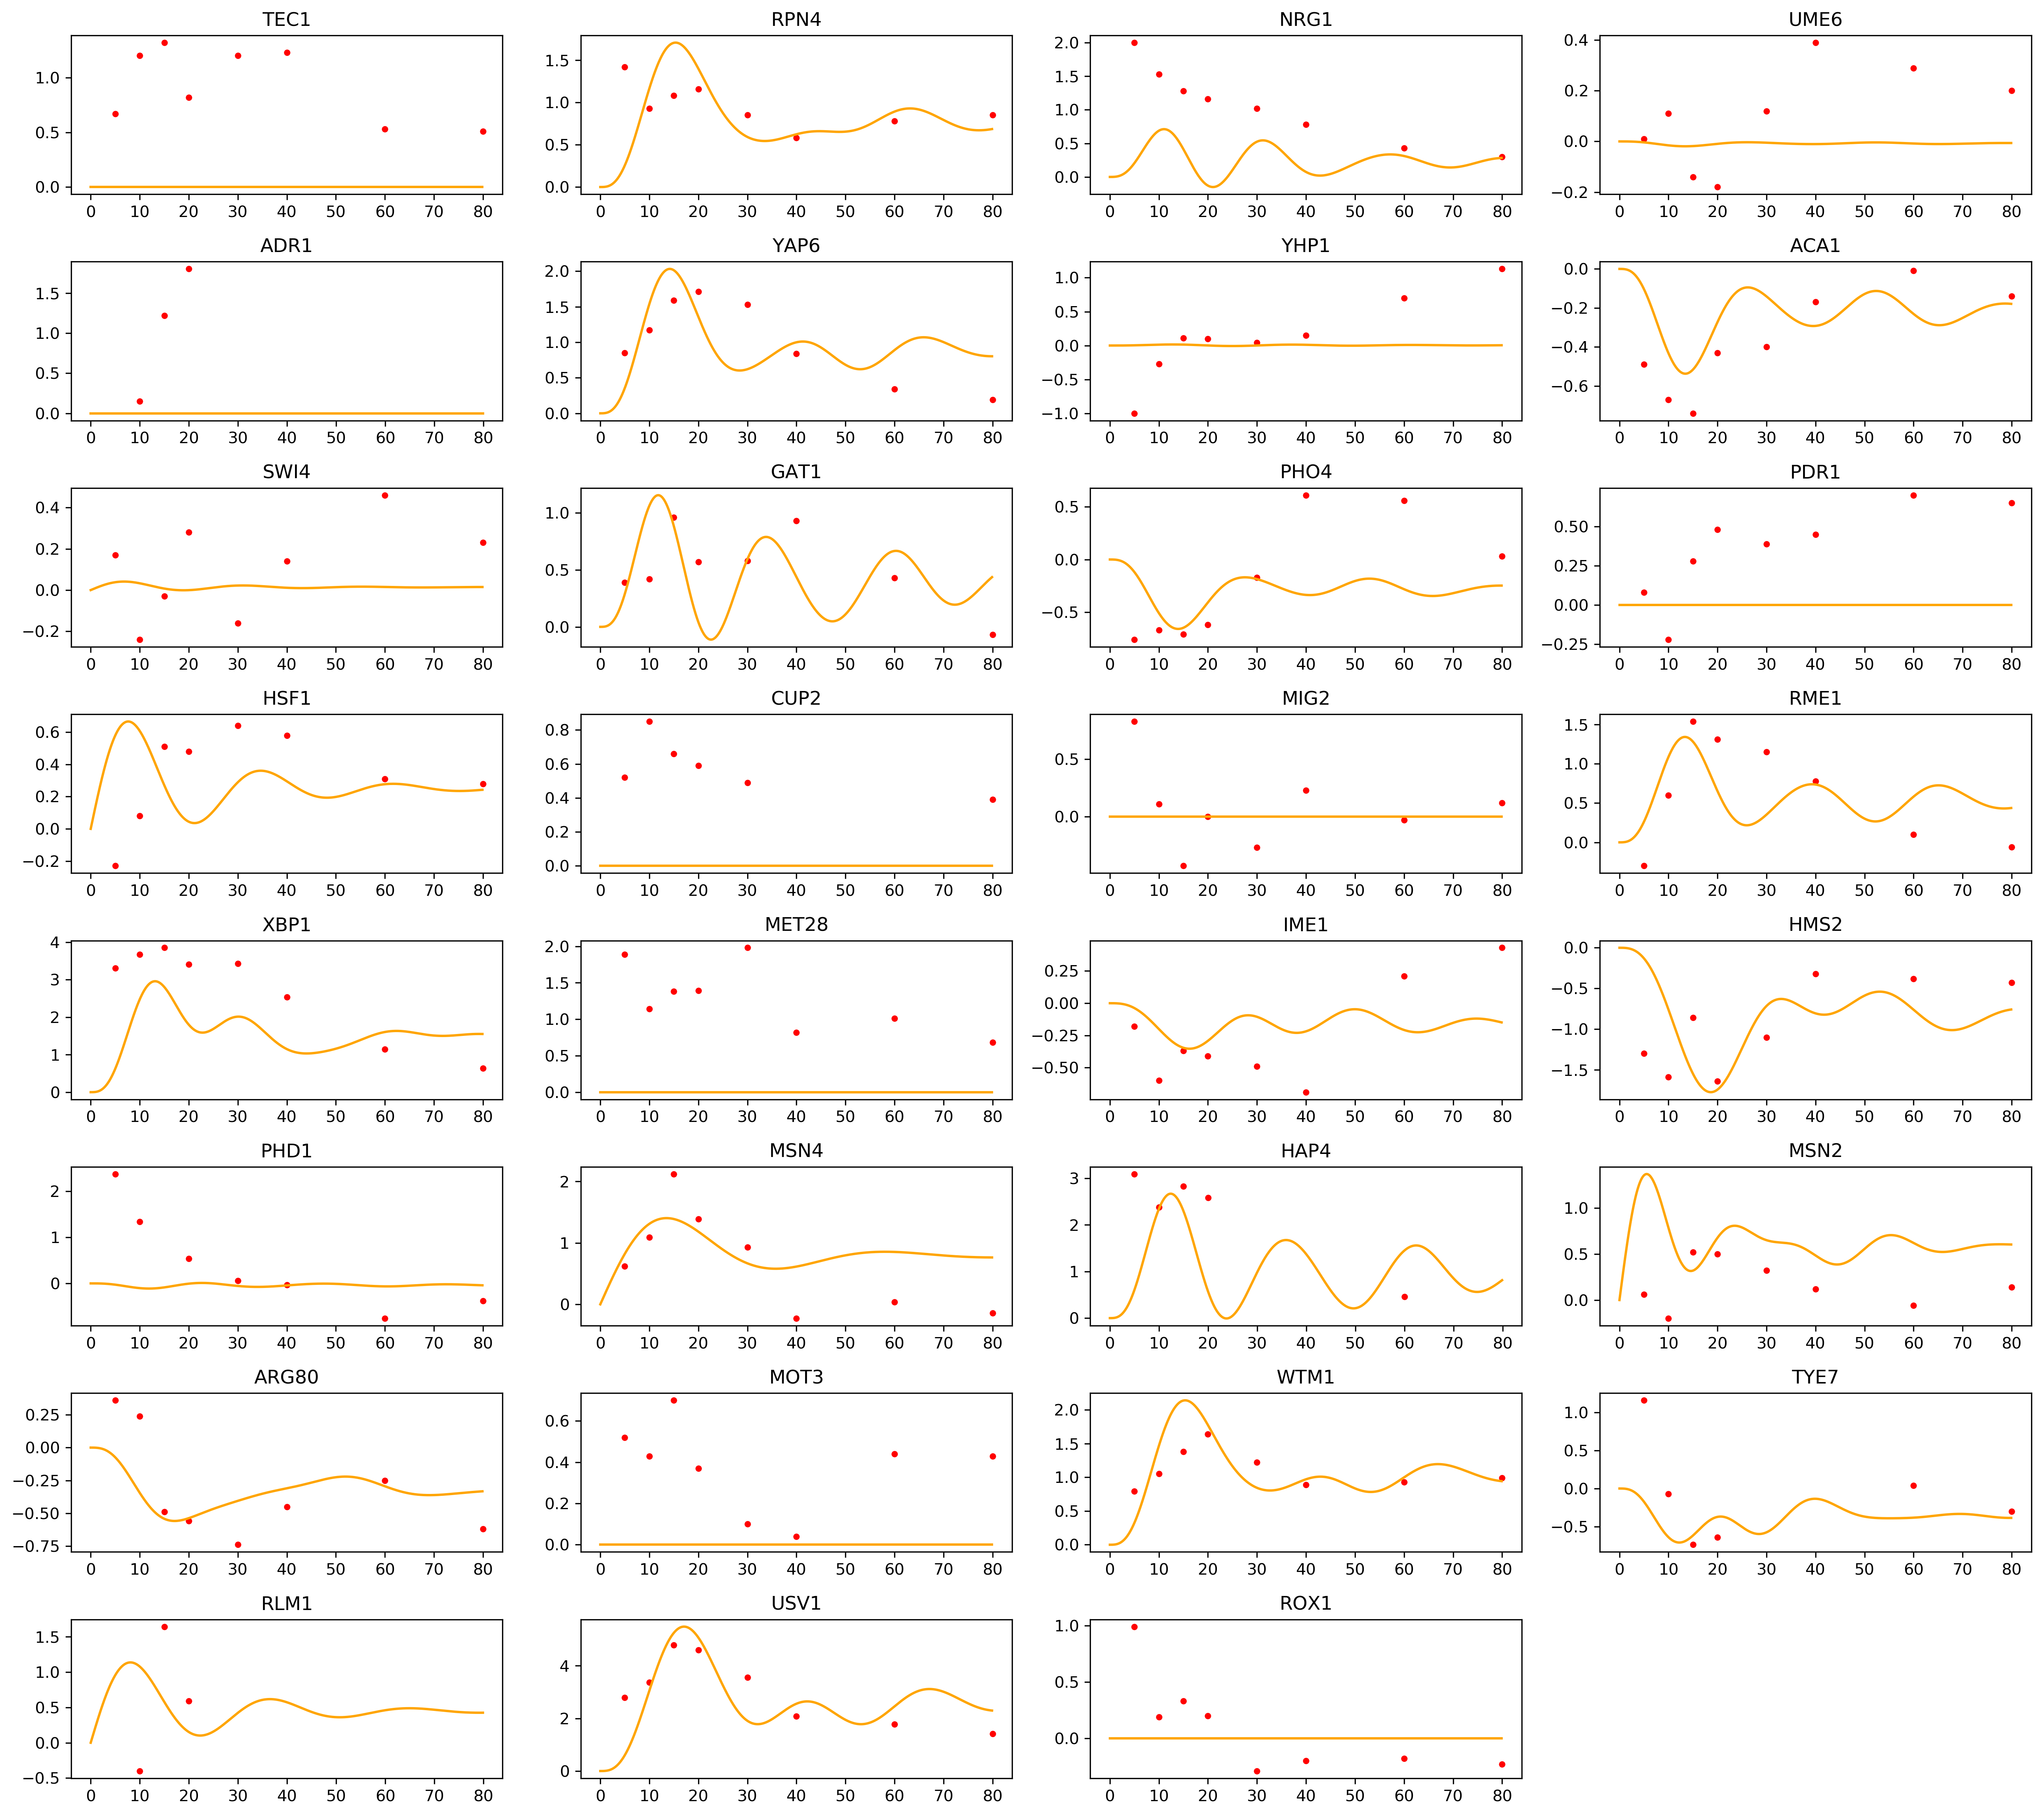

In [10]:
# Change time to sample from model to have higher resolution.
ts = np.arange(0, 80, 0.1)
y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]

plt.figure(figsize=(18, 16), dpi=300)
for i, node in enumerate(nodes1):
    plt.subplot(8, 4, i + 1)
    plt.plot(times[1:], y_data.iloc[i,:], '.', color="red")
    plt.plot(ts, y_pred[:, i], '-', color="orange")
    plt.title(node)
    #plt.plot(times, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '.-', color = 'red', alpha=0.3)
    #plt.xlim(0, 80)
    #plt.ylim(-2, 3)
plt.tight_layout()
plt.show()